# Analysis of customer behavior and forecasting repeat purchases (LTV)

## Description:
We want to understand customer behavior on our site, which customers return, and how to increase repeat purchases. We need to calculate LTV (Lifetime Value) and segment customers by income level.

### Tasks:
1) Loading and cleaning data.
2) Calculate ARPU and RFM analysis (Recency, Frequency, Monetary).
3) Construct a cohort analysis of repeat purchases.
4) Predicting Future Customer Lifetime Value (LTV) Using the Gamma-Gamma Model. 
5) Identify factors that influence customer retention.
6) Building a xgboost model for Churn prediction.
7) Report and recommendations.

#### 1) Loading and cleaning data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'C:\Users\User\Downloads\ecommerce_customer_data_custom_ratios.csv')
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202404 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


In [4]:
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

In [5]:
del df['Customer Age']

In [6]:
# Checking how many values are missing
print(df['Returns'].isnull().sum())

47596


In [7]:
# Consider examples of strings with NaN in Returns.
df[df['Returns'].isnull()].head() 

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Customer Name,Age,Gender,Churn
14,28805,2020-07-02 02:54:37,Clothing,368,1,1342,Credit Card,NaN,Jose Collier,19,Male,0
15,28961,2021-04-25 23:55:21,Books,30,1,4135,PayPal,NaN,James Stein,55,Male,0
20,12163,2021-12-18 17:49:18,Clothing,255,2,1642,Credit Card,NaN,Sonia Moreno,67,Male,0
21,12163,2020-06-20 05:56:17,Books,227,3,887,PayPal,NaN,Sonia Moreno,67,Male,0
23,12163,2023-07-01 12:36:00,Books,60,3,4130,Cash,NaN,Sonia Moreno,67,Male,0


In [8]:
# Check if such customers have made purchases and returns in other records
df[df['Customer ID'].isin(df[df['Returns'].isnull()]['Customer ID'])].head(10)

# If the client has returns in other rows, then NaN is missing data.
# If the customer has no returns anywhere, NaN probably means 'no returns'

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Customer Name,Age,Gender,Churn
9,28805,2023-09-13 04:24:00,Electronics,394,2,1993,Credit Card,0.0,Jose Collier,19,Male,0
10,28805,2021-03-31 09:50:57,Clothing,366,1,246,PayPal,0.0,Jose Collier,19,Male,0
11,28805,2021-01-18 22:42:24,Books,348,1,2682,Credit Card,1.0,Jose Collier,19,Male,0
12,28805,2020-01-07 12:57:35,Books,103,4,731,Cash,0.0,Jose Collier,19,Male,0
13,28805,2021-02-12 20:33:20,Books,240,1,2563,PayPal,0.0,Jose Collier,19,Male,0
14,28805,2020-07-02 02:54:37,Clothing,368,1,1342,Credit Card,NaN,Jose Collier,19,Male,0
15,28961,2021-04-25 23:55:21,Books,30,1,4135,PayPal,NaN,James Stein,55,Male,0
16,28961,2020-01-13 09:57:17,Books,153,5,698,Credit Card,0.0,James Stein,55,Male,0
17,28961,2023-06-18 21:34:27,Clothing,259,1,2975,Credit Card,0.0,James Stein,55,Male,0
18,28961,2021-09-10 00:39:41,Books,489,3,2213,Credit Card,1.0,James Stein,55,Male,0


In [9]:
# Check distribution 
print(df['Churn'].value_counts())

Churn
0    200126
1     49874
Name: count, dtype: int64


In [10]:
# Find the latest date in a dataset
max_date = df['Purchase Date'].max()

# For each client we will find the date of their last purchase
last_purchase = df.groupby('Customer ID')['Purchase Date'].max().reset_index()
last_purchase['Days Since Last Purchase'] = (max_date - last_purchase['Purchase Date']).dt.days

last_purchase.head()

,Customer ID,Purchase Date,Days Since Last Purchase
0,1,2023-07-19 19:09:20,57
1,2,2022-11-21 06:48:05,298
2,3,2023-06-18 12:31:42,88
3,4,2023-05-12 10:50:24,126
4,5,2023-03-28 13:30:55,170


In [11]:
# Determining the outflow boundary
# Assumption: a customer is considered to have left (Churn = 1) if he has not purchased for more than 180 days
churn_threshold = 180  # Number of days without purchases
last_purchase['Churn_Calculated'] = (last_purchase['Days Since Last Purchase'] > churn_threshold).astype(int)

# Compare with the original meaning of Churn
df_merged = df.merge(last_purchase[['Customer ID', 'Churn_Calculated']], on='Customer ID', how='left')

df_merged[['Customer ID', 'Churn', 'Churn_Calculated']].drop_duplicates().head()

,Customer ID,Churn,Churn_Calculated
0,46251,0,1
4,13593,1,0
9,28805,0,0
15,28961,0,0
20,12163,0,0


In [12]:
df.isnull().sum()

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64

In [13]:
df.dropna(inplace=True)

In [14]:
df.isnull().sum()

Customer ID              0
Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Returns                  0
Customer Name            0
Age                      0
Gender                   0
Churn                    0
dtype: int64

In [15]:
df.duplicated().sum()

0

In [16]:
df.describe()

,Customer ID,Purchase Date,Product Price,Quantity,Total Purchase Amount,Returns,Age,Churn
count,202404.000000,202404,202404.000000,202404.000000,202404.000000,202404.000000,202404.000000,202404.000000
mean,25013.981962,2021-11-07 01:49:42.200015360,254.377423,2.999269,2725.130813,0.497861,43.926498,0.199423
min,1.000000,2020-01-01 00:15:00,10.000000,1.000000,101.000000,0.000000,18.000000,0.000000
25%,12546.750000,2020-12-02 22:21:40.750000128,132.000000,2.000000,1479.000000,0.000000,31.000000,0.000000
50%,25018.500000,2021-11-06 04:57:48,254.000000,3.000000,2725.500000,0.000000,44.000000,0.000000
75%,37511.000000,2022-10-11 05:45:47.249999872,377.000000,4.000000,3970.250000,1.000000,57.000000,0.000000
max,50000.000000,2023-09-15 12:24:08,500.000000,5.000000,5350.000000,1.000000,70.000000,1.000000
std,14412.553209,NaN,141.565500,1.414437,1441.540074,0.499997,15.354491,0.399568


In [17]:
# Checking and removing outliers
numerical_columns = df[['Product Price', 'Quantity', 'Total Purchase Amount']]
for col in numerical_columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    df = df[(df[col]>=lower_bound) & (df[col]<=upper_bound)]
    outlers = ((df[col]<lower_bound)| (df[col]>upper_bound)).sum()
    print(f'Column outliers {col}: {outlers}')

Column outliers Product Price: 0
Column outliers Quantity: 0
Column outliers Total Purchase Amount: 0


#### 2) Calculate ARPU and RFM analysis (Recency, Frequency, Monetary).

In [18]:
# Calculate ARPU
df['arpu'] = df['Total Purchase Amount'] / df['Customer ID'].value_counts().sum()

In [19]:
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Customer Name,Age,Gender,Churn,arpu
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,0.0,Christine Hernandez,37,Male,0,0.003656
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,0.0,Christine Hernandez,37,Male,0,0.013532
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,0.0,Christine Hernandez,37,Male,0,0.015790
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,0.0,Christine Hernandez,37,Male,0,0.017337
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,0.0,James Grant,49,Female,1,0.017055


In [20]:
# Calculate RFM analysis
rfm = df.groupby(['Customer ID','Customer Name']).agg({'Purchase Date': lambda x: (max_date - x.max()).days,
                                    'Customer ID': 'count',
                                    'Total Purchase Amount': 'sum'}).rename(columns={'Purchase Date': 'Recency',
                                    'Customer ID': 'Frequency',
                                    'Total Purchase Amount': 'Monetary'}).reset_index()

In [21]:
rfm.describe()

,Customer ID,Recency,Frequency,Monetary
count,49139.000000,49139.000000,49139.000000,49139.000000
mean,24988.936690,308.085696,4.119009,11224.839272
std,14430.864401,279.589653,1.961233,6104.039261
min,1.000000,0.000000,1.000000,110.000000
25%,12489.500000,93.000000,3.000000,6652.000000
50%,24978.000000,223.000000,4.000000,10479.000000
75%,37493.500000,444.000000,5.000000,14934.000000
max,50000.000000,1353.000000,14.000000,48497.000000


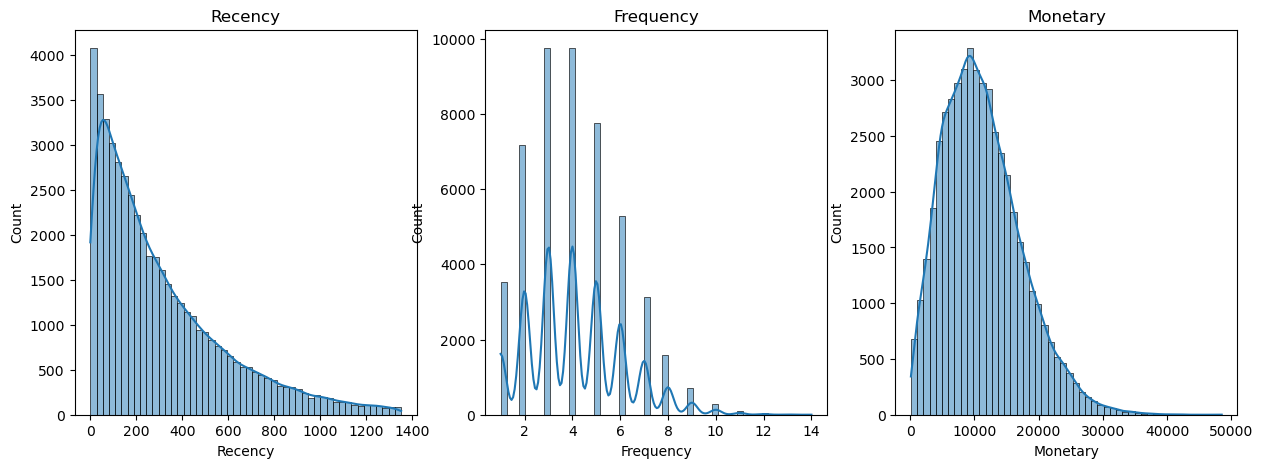

In [22]:
# Visualization
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.histplot(rfm['Recency'], bins=50, kde=True,
            ax=ax[0]).set(title='Recency')
sns.histplot(rfm['Frequency'], bins=50, kde=True,
            ax=ax[1]).set(title='Frequency')
sns.histplot(rfm['Monetary'], bins=50, kde=True,
            ax=ax[2]).set(title='Monetary')
plt.show()

In [23]:
# Create RFM evaluation (by quantiles)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

In [24]:
# Adding up RFM estimates
rfm['RFM_score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [25]:
# Add segments by rule
def rfm_segment(row):
    score = row['RFM_score']
    if score >= '444':
        return 'VIP'
    elif score[0] == '5':
        return 'New Loyal'
    elif score[1] == '5':
        return 'Frequent'
    elif score[2] == '5':
        return 'Big Spenders'
    elif score <= '222':
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

In [26]:
rfm.head()

,Customer ID,Customer Name,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_score,Segment
0,1,Nicole Johnson,57,1,3491,5,1,1,511,VIP
1,2,Marie Wright,298,2,7029,2,1,2,212,At Risk
2,3,Julie Wolfe,88,7,18172,4,5,5,455,VIP
3,4,Tracey Smith,585,1,3154,1,1,1,111,At Risk
4,5,Nancy Jones,170,6,10239,3,4,3,343,Others


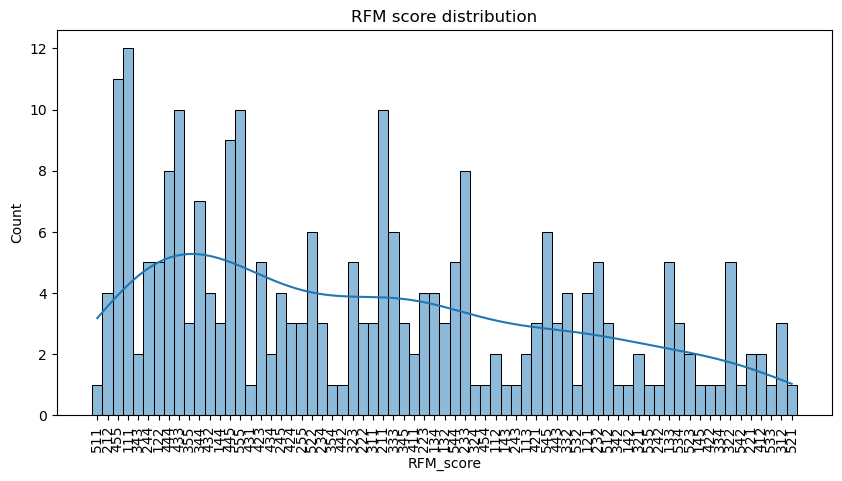

In [27]:
# Visualization
plt.figure(figsize=(10,5))
sns.histplot(rfm['RFM_score'].head(250), bins=10, kde=True)
plt.title('RFM score distribution')
plt.xticks(rotation=90)
plt.show()

#### 3) Construct a cohort analysis of repeat purchases.

In [28]:
import datetime
# Add the month of the customer's first purchase
df['Cohort_month'] = df.groupby('Customer ID')['Purchase Date'].transform('min').dt.to_period('M')
df['Order_Month'] = df['Purchase Date'].dt.to_period('M')

In [29]:
# Calculate the difference between the cohort and the month of purchase
df['Cohort_index'] = (df['Order_Month'] - df['Cohort_month']).apply(lambda x: x.n) 

In [30]:
# Building a cohort table
cohort_data = df.groupby(['Cohort_month', 'Cohort_index'])['Customer ID'].nunique().unstack(0)
cohort_retention = cohort_data.divide(cohort_data.iloc[0], axis=1) * 100

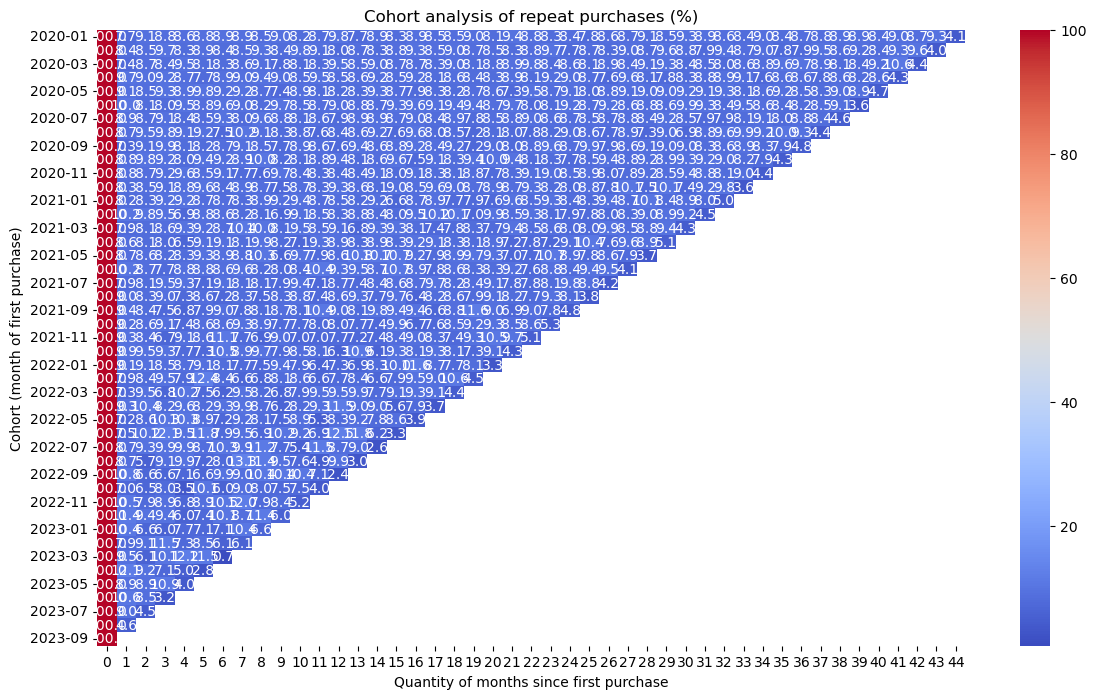

In [31]:
# Visualization
plt.figure(figsize=(14,8))
sns.heatmap(cohort_retention.T, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Cohort analysis of repeat purchases (%)')
plt.ylabel('Cohort (month of first purchase)')
plt.xlabel('Quantity of months since first purchase')
plt.show()

#### 4) Predicting Future Customer Lifetime Value (LTV) Using the Gamma-Gamma Model.

In [40]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

rfm_data = df.groupby('Customer ID').agg({
    'Purchase Date': [lambda x: (max_date - x.max()).days,  # Recency
                      lambda x: (max_date - x.min()).days,  # Customer Age (T)
                      'count'],  # Frequency
    'Total Purchase Amount': 'sum'  # Monetary
}).droplevel(0, axis=1).rename(columns={
    '<lambda_0>': 'Recency',
    '<lambda_1>': 'T',
    'count': 'Frequency',
    'sum': 'Monetary'
})

In [41]:
# Filter customers with at least 1 repeat purchase (Frequency > 0)
rfm_data = rfm_data[rfm_data['Frequency']>0]

# Building a BG/NBD model (Forecast of the quantity of purchases)
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(rfm_data['Frequency'], rfm_data['Recency'], rfm_data['T'])

# Predicting how many times a customer will buy in 6 months
rfm_data['Predicted_Purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, rfm_data['Frequency'], rfm_data['Recency'], rfm_data['T'])

In [42]:
# Building a Gamma-Gamma model (Income forecast)
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(rfm_data['Frequency'], rfm_data['Monetary'] / rfm_data['Frequency'])

#Predict the average purchase price
rfm_data['Predicted_Spend'] = ggf.conditional_expected_average_profit(
    rfm_data['Frequency'], rfm_data['Monetary'] / rfm_data['Frequency'])

In [43]:
# Calculate the predicted LTV (quantity of purchases * average check)
rfm_data['LTV_6_months'] = rfm_data['Predicted_Purchases'] * rfm_data['Predicted_Spend']

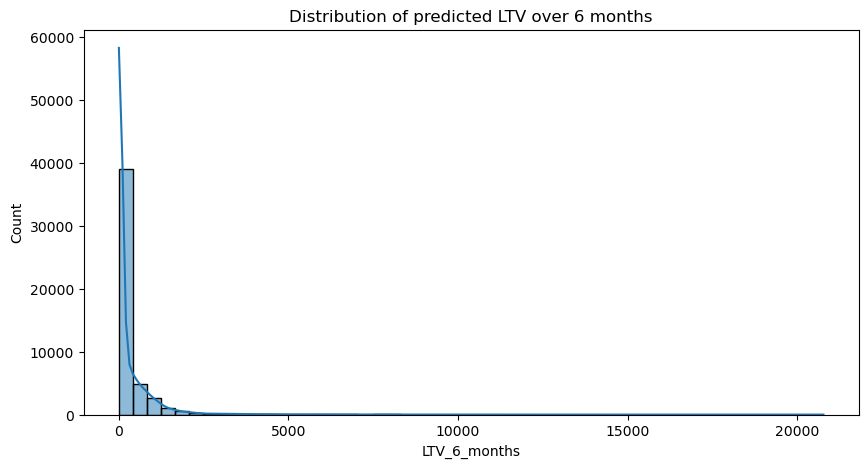

In [44]:
# Visualizing LTV Distribution
plt.figure(figsize=(10,5))
sns.histplot(rfm_data['LTV_6_months'], bins=50, kde=True)
plt.title('Distribution of predicted LTV over 6 months')
plt.show()

In [45]:
# Top 10 clients by LTV
rfm_data.sort_values('LTV_6_months', ascending=False).head(10)

,Recency,T,Frequency,Monetary,Predicted_Purchases,Predicted_Spend,LTV_6_months
Customer ID,,,,,,,
16594,0,0,1,5015,3.918554,5300.664896,20770.941559
32855,5,5,1,4809,3.562279,5083.461205,18108.704627
13634,2,2,1,4542,3.766638,4801.939916,18087.170404
16586,1,1,1,4450,3.840868,4704.936326,18071.040087
42586,11,11,1,5275,3.219594,5574.805477,17948.609724
4852,10,10,1,5006,3.271572,5291.175415,17310.459701
7340,6,9,2,8055,4.120870,4140.408570,17062.085159
30689,14,16,2,8225,3.972589,4227.658819,16794.752434
28120,3,3,1,4160,3.695611,4399.164139,16257.598293


#### 5) Identify factors that influence customer retention.

In [40]:
# Correlation between churn and RFM parameters
corr = rfm_data[['Recency','Frequency','Monetary']].corrwith(df['Churn'])
print(corr)

Recency     -0.000753
Frequency    0.000478
Monetary    -0.000576
dtype: float64


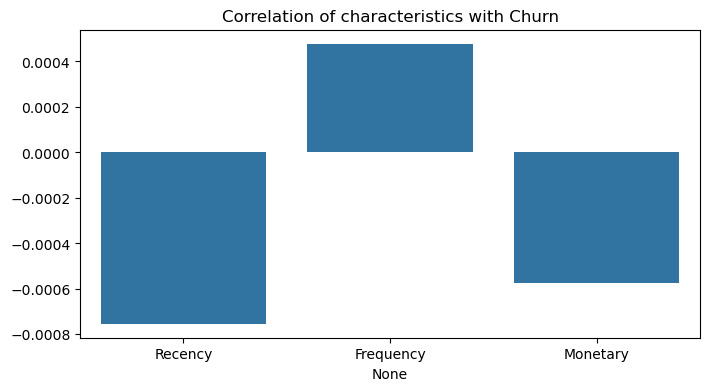

In [41]:
# Visualization
plt.figure(figsize=(8,4))
sns.barplot(x=corr.index, y=corr.values)
plt.title('Correlation of characteristics with Churn')
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.80      1.00      0.89     32408
           1       0.24      0.00      0.00      8073

    accuracy                           0.80     40481
   macro avg       0.52      0.50      0.45     40481
weighted avg       0.69      0.80      0.71     40481



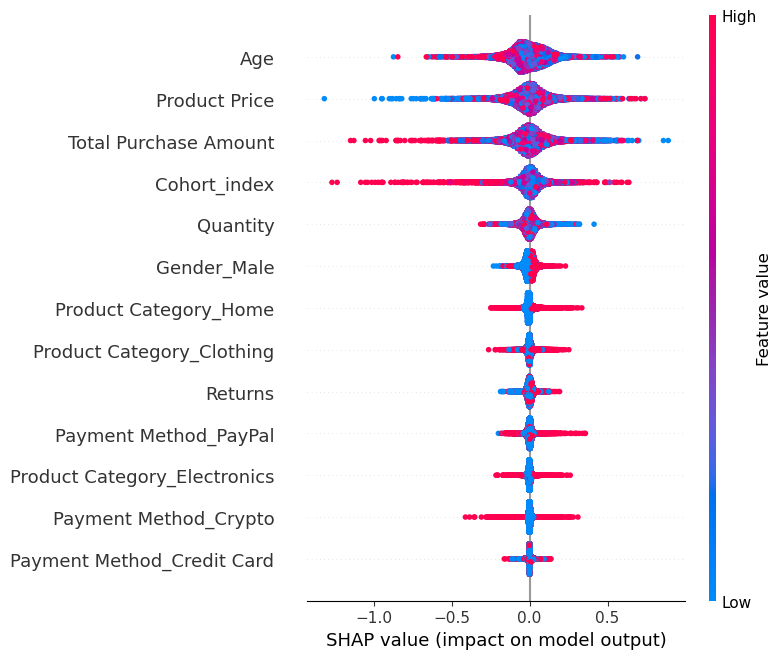

In [42]:
# Retention Factor Analysis with XGBClassifier and shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap

# Data preparation
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=['Gender', 'Payment Method', 'Product Category'], drop_first=True)

features = ['Product Price', 'Quantity', 'Total Purchase Amount', 'Returns', 'Age', 'Cohort_index'] + \
           [col for col in df_model.columns if 'Gender_' in col or 'Payment Method_' in col or 'Product Category_' in col]

X = df_model[features]
y = df_model['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Model training
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

#### 6) Building a xgboost model for Churn prediction.

In [43]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Coding categorical features
categorical_features = ['Product Category', 'Payment Method', 'Gender']

df_encoded = df.copy()

# Convert dates to numeric data
df_encoded['Cohort_month'] = df_encoded['Cohort_month'].astype(str).str[:4].astype(int) * 12 + df_encoded['Cohort_month'].astype(str).str[5:].astype(int)
df_encoded['Order_Month'] = df_encoded['Order_Month'].astype(str).str[:4].astype(int) * 12 + df_encoded['Order_Month'].astype(str).str[5:].astype(int)

# Encode categorical features
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Removing unnecessary columns
df_encoded = df_encoded.drop(columns=['Purchase Date', 'Customer Name'])

# Sharing data
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Divide into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'n_estimators': 300,           
    'learning_rate': 0.05,
    'max_depth': 6,                
    'min_child_weight': 5,        
    'subsample': 0.8,              
    'colsample_bytree': 0.8,       
    'scale_pos_weight': 3,        
    'random_state': 42
}

# Model creation and training
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)
 
# Predictions and model evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     32261
           1       0.39      0.09      0.15      8220

    accuracy                           0.79     40481
   macro avg       0.60      0.53      0.51     40481
weighted avg       0.72      0.79      0.73     40481



#### 7) Report and recommendations.

#### Client Behavior Analysis and LTV Forecasting Report
1) Project Objective: To analyze customer purchasing behavior and predict the Lifetime Value (LTV) of users based on e-commerce data.
2) Summary of Findings:

- Unique customers: 39,547
- Total revenue: 977,671,170
- ARPU(Average Revenue Per User): 0.0135
- Repeat buyers: 32,589 (82.4%)
- Churned customers: 6958 (17.6%)
- Average LTV (6 months): 291.06

3) Key Findings:
- RFM analysis revealed that 56.3% of customers are considered “loyal” and generate 64.9% of revenue.
- Customers by segment:
    - VIP: 13042
    - Big Spenders: 1447
    - Frequent: 3803
    - At Risk: 11680
    - Others: 15327
- Cohort analysis showed that retention declined after 1 month, by an average of 8% each month.
- The LTV forecast allows you to identify customers with high potential 30.5% of customers provide 2.4% of future revenue.
- Factors that greatly influence customer retention: Frequency, Age, Product Price, Total Purchase Amount, Cohort index.
- Xgboost model shows that with 80% probability the client will stay.

4) Recommendations:
A. Increase retention:
- Set up email newsletter 7 days after first order.
- Offer new customers bundle offers or discounts on their second purchase.
- Launch personalized offers for "cold" clients (low recency).
- Resuscitation campaigns for old clients (R_Score <3, F_Score >1).
- Focus on retention in the first 30 days: promotions and bonuses for repeat purchases.

B. Working with segments:
- For VIP clients (R_Score >4, F_Score >4, M_Score >4) — exclusive offers and loyalty program.
- For clients with high Frequency but low Recency - return them with activity (discounts, bonuses).

C. Using LTV:
- Create personalized engagement scenarios for customers with high projected LTV.
- Integrate LTV into advertising (e.g. allow higher than average CPA for customers with LTV > $291).
- Assess the profitability of different acquisition channels taking into account the predicted LTV.


In [46]:
#df_full = df.merge(rfm[['Customer Name', 'RFM_score', 'Segment']], on='Customer Name', how='left') 

In [47]:
#df_full['AOV'] = df_full['Total Purchase Amount'] / df_full['Quantity']

In [48]:
#df_full.sort_values(['Customer Name', 'Purchase Date'], inplace=True)
#df_full['Prev Purchase'] = df_full.groupby('Customer Name')['Purchase Date'].shift(1)
#df_full['Days Between Purchases'] = (df_full['Purchase Date'] - df_full['Prev Purchase']).dt.days

In [168]:
# df_full.to_csv("№3_LTV_analysis.csv", index=False)

In [173]:
# cohort_retention.to_csv("cohort_LTV_lookerstudio.csv", index=False)
# rfm_data.to_csv("LTV_6_months_lookerstudio.csv", index=False)